Projeto de classificação de doenças nas folhas da soja


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Minhas importações
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical


dataset_path = "/content/drive/MyDrive/SoyNet_Separado"


In [1]:
#Conferindo meu total de imagens inicial...
import os

dataset_path = "/content/drive/MyDrive/SoyNet_Separado"
disease_path = os.path.join(dataset_path, "Grayscale_Disease_data")
healthy_path = os.path.join(dataset_path, "Grayscale_Healthy_data")

def contar_imagens(caminho):
    return len([f for f in os.listdir(caminho) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

num_doentes = contar_imagens(disease_path)
num_saudaveis = contar_imagens(healthy_path)

print(f"Total de imagens doentes: {num_doentes}")
print(f"Total de imagens saudáveis: {num_saudaveis}")
print(f"Total geral de imagens: {num_doentes + num_saudaveis}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/SoyNet_Separado/Grayscale_Disease_data'

In [ ]:
#Função para carregar, redimensionar e rotular imagens
def load_images_from_folder(folder_path, label, image_size=(64, 64)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, image_size)
            img_flat = img.flatten()
            images.append(img_flat)
            labels.append(label)
    return images, labels


In [ ]:
disease_path = os.path.join(dataset_path, "Grayscale_Disease_data")
healthy_path = os.path.join(dataset_path, "Grayscale_Healthy_data")

disease_images, disease_labels = load_images_from_folder(disease_path, label=1)
healthy_images, healthy_labels = load_images_from_folder(healthy_path, label=0)

X = disease_images + healthy_images
y = disease_labels + healthy_labels

X = np.array(X)
y = np.array(y)

In [ ]:
#Treinamento Random Forest, SVM e CNN
path_doente = "/content/drive/MyDrive/SoyNet_Separado/Grayscale_Disease_data"
path_saudavel = "/content/drive/MyDrive/SoyNet_Separado/Grayscale_Healthy_data"


def carregar_imagens_flat(caminho, rotulo):
    imagens = []
    for arquivo in os.listdir(caminho):
        if arquivo.lower().endswith(".jpg"):
            img = cv2.imread(os.path.join(caminho, arquivo), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_redimensionada = cv2.resize(img, (64, 64)).flatten()
                imagens.append((img_redimensionada, rotulo))
    return imagens


def carregar_imagens_cnn(caminho, rotulo):
    imagens = []
    for arquivo in os.listdir(caminho):
        if arquivo.lower().endswith(".jpg"):
            img = cv2.imread(os.path.join(caminho, arquivo), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_redimensionada = cv2.resize(img, (64, 64))
                imagens.append((img_redimensionada, rotulo))
    return imagens

dados_flat = carregar_imagens_flat(path_doente, 1) + carregar_imagens_flat(path_saudavel, 0)
X_flat, y_flat = zip(*dados_flat)
X_flat = np.array(X_flat)
y_flat = np.array(y_flat)

scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_flat, y_flat, test_size=0.2, random_state=42)


modelos = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC()
}

for nome, modelo in modelos.items():
    modelo.fit(X_train_f, y_train_f)
    y_pred = modelo.predict(X_test_f)
    print(f"\nModelo: {nome}")
    print("Acurácia:", accuracy_score(y_test_f, y_pred))
    print(classification_report(y_test_f, y_pred))



dados_cnn = carregar_imagens_cnn(path_doente, 1) + carregar_imagens_cnn(path_saudavel, 0)
X_cnn, y_cnn = zip(*dados_cnn)
X_cnn = np.array(X_cnn).reshape(-1, 64, 64, 1) / 255.0
y_cnn = to_categorical(y_cnn)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=42)


modelo_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

modelo_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\nTreinando CNN...")
modelo_cnn.fit(X_train_c, y_train_c, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

loss, acc = modelo_cnn.evaluate(X_test_c, y_test_c, verbose=0)
print("\nModelo: CNN")
print("Acurácia:", acc)




Modelo: Random Forest
Acurácia: 0.9623430962343096
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        20
           1       0.98      0.98      0.98       219

    accuracy                           0.96       239
   macro avg       0.87      0.89      0.88       239
weighted avg       0.96      0.96      0.96       239


Modelo: SVM
Acurácia: 0.9539748953974896
              precision    recall  f1-score   support

           0       1.00      0.45      0.62        20
           1       0.95      1.00      0.98       219

    accuracy                           0.95       239
   macro avg       0.98      0.72      0.80       239
weighted avg       0.96      0.95      0.95       239



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Treinando CNN...
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.8071 - loss: 0.4126 - val_accuracy: 0.8534 - val_loss: 0.3317
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.8729 - loss: 0.2962 - val_accuracy: 0.8534 - val_loss: 0.3127
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.8973 - loss: 0.2123 - val_accuracy: 0.8691 - val_loss: 0.2831
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9018 - loss: 0.1986 - val_accuracy: 0.8848 - val_loss: 0.2577
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9153 - loss: 0.1702 - val_accuracy: 0.9267 - val_loss: 0.2586
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.9497 - loss: 0.1671 - val_accuracy: 0.9162 - val_loss: 0.2476
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9492 - loss: 0.1218 - val_accuracy: 0.9162 - val_loss: 0.2739
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9507 - loss: 0.1126 

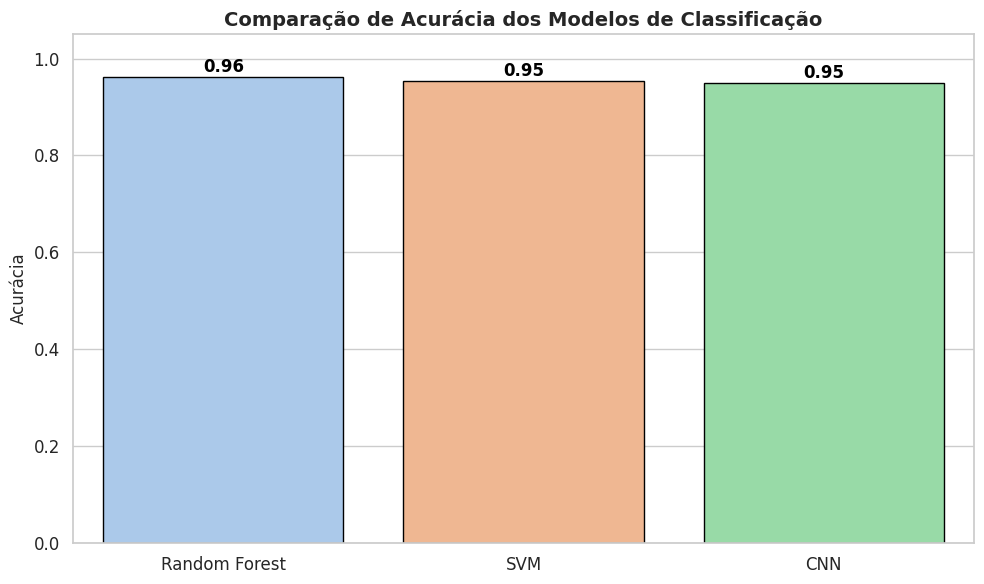

In [ ]:

# Cria o dicionário com as acurácias
resultados = {
    "Random Forest": accuracy_score(y_test_f, modelos["Random Forest"].predict(X_test_f)),
    "SVM": accuracy_score(y_test_f, modelos["SVM"].predict(X_test_f)),
    "CNN": acc  # acurácia da CNN já calculada anteriormente
}

# Conversão em dataframe
df_resultados = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'Acurácia': list(resultados.values())
})


sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_resultados,
    x='Modelo',
    y='Acurácia',
    hue='Modelo',
    palette='pastel',
    edgecolor='black',
    dodge=False,
    legend=False
)

# Add os valores no topo das barras
for index, row in df_resultados.iterrows():
    barplot.text(index, row.Acurácia + 0.01, f"{row.Acurácia:.2f}",
                 color='black', ha="center", fontweight='bold', fontsize=12)

plt.title('Comparação de Acurácia dos Modelos de Classificação', fontsize=14, fontweight='bold')
plt.ylim(0, 1.05)
plt.xlabel('')
plt.ylabel('Acurácia', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


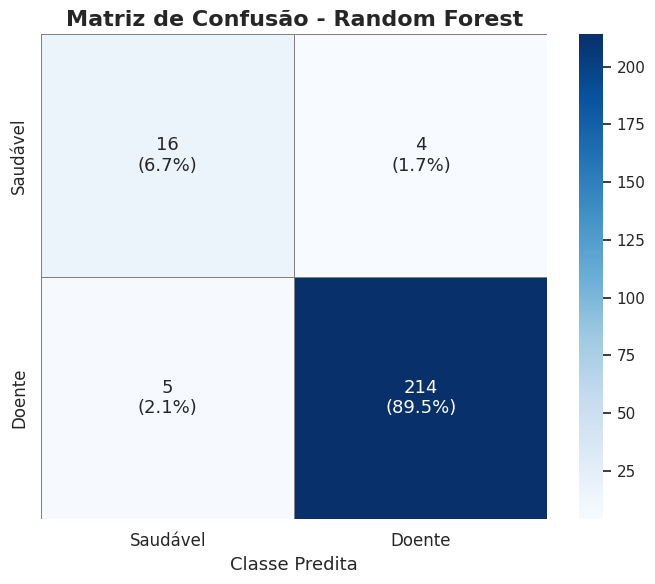

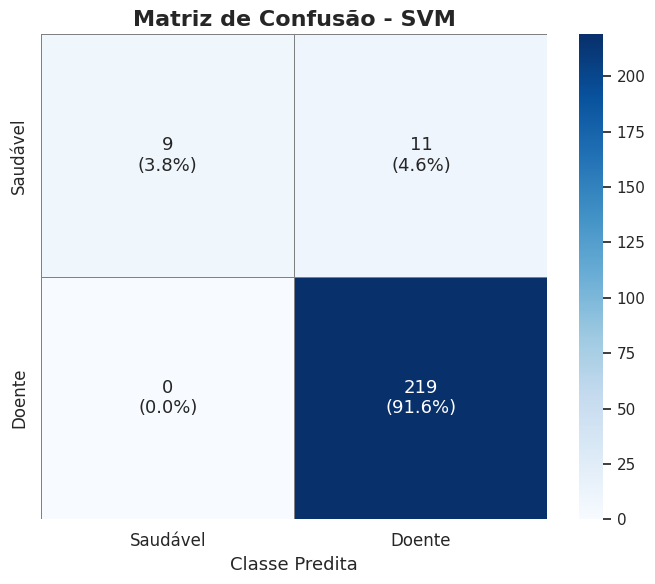

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


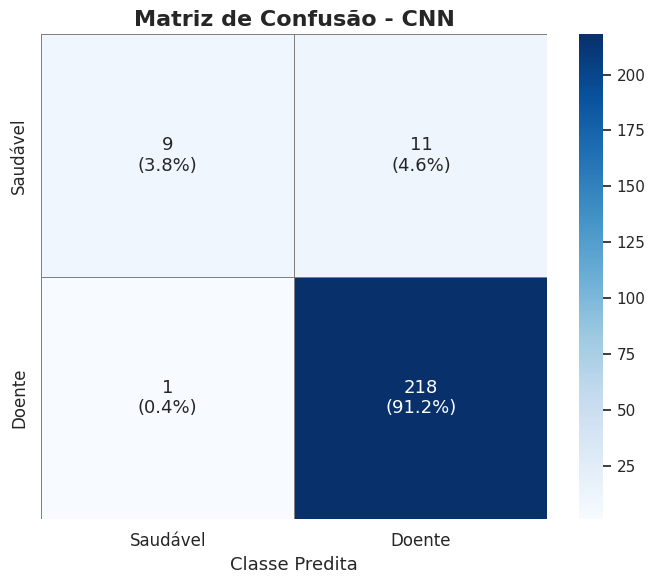

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de confusão com valores + porcentagem
def plot_matriz_confusao_com_percentual(cm, title, labels):
    plt.figure(figsize=(7,6))
    cm_sum = np.sum(cm)
    cm_percentage = (cm / cm_sum) * 100
    annot = np.empty_like(cm).astype(str)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            c = cm[i, j]
            p = cm_percentage[i, j]
            annot[i, j] = f'{c}\n({p:.1f}%)'

    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                cbar=True, annot_kws={"size": 13},
                xticklabels=labels, yticklabels=labels,
                linewidths=0.7, linecolor='gray')

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Classe Predita', fontsize=13)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

#Para Random Forest e SVM
for nome, modelo in modelos.items():
    y_pred = modelo.predict(X_test_f)
    cm = confusion_matrix(y_test_f, y_pred)
    plot_matriz_confusao_com_percentual(cm, f'Matriz de Confusão - {nome}', ["Saudável", "Doente"])

# Para CNN
y_pred_cnn = modelo_cnn.predict(X_test_c)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_test_c_classes = np.argmax(y_test_c, axis=1)

cm_cnn = confusion_matrix(y_test_c_classes, y_pred_cnn_classes)
plot_matriz_confusao_com_percentual(cm_cnn, "Matriz de Confusão - CNN", ["Saudável", "Doente"])
